# Library imports

In [ ]:
#Classic imports
import numpy as np 
import pandas as pd 
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import os 
from google.colab import files

# Import English using en_core_web_sm.load()
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS

import html
import re
import nltk
nltk.download('wordnet')
import wordcloud
from wordcloud import WordCloud,STOPWORDS
import gensim
from nltk.stem import WordNetLemmatizer
import string 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the training data

In [ ]:
data_train = pd.read_csv("data/train.csv")

In [ ]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
data_train.shape

(7613, 5)

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
nlp = en_core_web_sm.load()

In [ ]:
print(len(data_train.keyword.unique()))
print(len(data_train.location.unique()))


222
3342


In [ ]:
data_train["keyword"].value_counts(ascending = False)[0:15]

fatalities     45
armageddon     42
deluge         42
sinking        41
body%20bags    41
harm           41
damage         41
fear           40
collided       40
siren          40
windstorm      40
outbreak       40
evacuate       40
twister        40
weapons        39
Name: keyword, dtype: int64

Let's not bother with the other columns as during our model the main objective is to recognize a real disaster from another

In [ ]:
data_train = data_train[['text','target']]
data_train.columns

Index(['text', 'target'], dtype='object')

In [ ]:
data_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
data_train['text'].value_counts()

11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...        10
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                               6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_     6
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                      6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                                  5
                                                                                                                                                ..
@ameenshaikh3 sir i just only wanted to make a point about @sureshpprabhu you made and said he is lying about bridge c

In [ ]:
data_train.drop_duplicates(subset=['text'], inplace = True)

In [ ]:
len(data_train["text"])

7503

In [ ]:
data_train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,on the flip side I'm at Walmart and there is a...,1
7606,Suicide bomber kills 15 in Saudi security site...,1
7608,Two giant cranes holding a bridge collapse int...,1


In [ ]:
data_train['number_of_words'] = data_train.text.apply(lambda x: len(x.split()))

In [ ]:
data_train['number_of_words'].sum()

111621

In [ ]:
data_train

,text,target,number_of_words
0,Our Deeds are the Reason of this #earthquake M...,1,13
1,Forest fire near La Ronge Sask. Canada,1,7
2,All residents asked to 'shelter in place' are ...,1,22
3,"13,000 people receive #wildfires evacuation or...",1,8
4,Just got sent this photo from Ruby #Alaska as ...,1,16
...,...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1,19
7605,on the flip side I'm at Walmart and there is a...,1,26
7606,Suicide bomber kills 15 in Saudi security site...,1,20
7608,Two giant cranes holding a bridge collapse int...,1,11


# Data exploration 

In [ ]:
pie = px.pie(data_train['target'].value_counts(), values=["target"])

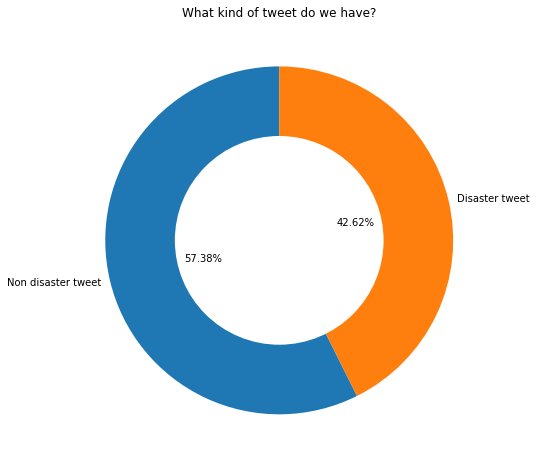

In [ ]:
plt.figure(figsize=(16,8))
data_train.target.value_counts(dropna=False).plot(kind='pie',autopct='%1.2f%%',pctdistance = 0.45, labels= ["Non disaster tweet", "Disaster tweet"], labeldistance = 1.05, startangle = 90)
plt.title('What kind of tweet do we have?')
plt.ylabel("")
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

In [ ]:
data_train.columns

Index(['text', 'target', 'number_of_words'], dtype='object')

In [ ]:
disaster_tweets = data_train[data_train["target"]==1]["text"].str.split().map(lambda x : len(x))

In [ ]:
no_disaster_tweets = data_train[data_train["target"]==0]["text"].str.split().map(lambda x : len(x))

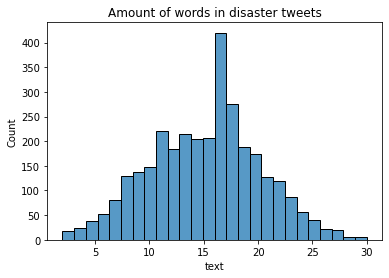

In [ ]:
fig = sns.histplot(data = disaster_tweets, palette = 'muted').set(title = "Amount of words in disaster tweets")

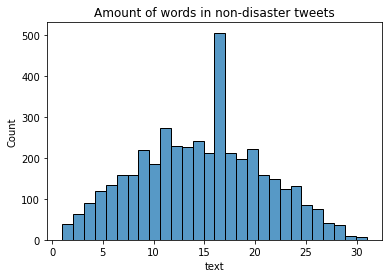

In [ ]:
fig = sns.histplot(data = no_disaster_tweets, palette = 'muted').set(title = "Amount of words in non-disaster tweets")

Pre-Preprocessing the data as we have raw tweets including a lot of extra words or characters that might create noise during our model

We've conducted a research on the state of the art and mainly used the code described here [Data cleaning](https://gist.github.com/bicachu/09cc71bb4b0e3711eaf1556b12fa7ad7) by John Bica  

In [ ]:
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'         # define a string of punctuation symbols

def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

#This might worsen our results as it removes essential words
def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_punct(tweet):
    table=str.maketrans('','',string.punctuation)
    return tweet.translate(table)

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet   

def remove_emojis(tweet):
    tweet = re.sub("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+",'', tweet)
    return tweet

def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = remove_emojis(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

def stopword_removal(tweet):
  return ' '.join([word for word in tweet.split() if word not in STOP_WORDS])

def lemmatization(token):
  return WordNetLemmatizer().lemmatize(token, pos='v')

def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    #tweet = remove_hashtags(tweet)
    tweet = remove_punct(tweet)
    tweet = remove_av(tweet)
    tweet = remove_emojis(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.sub('📝 …', '', tweet)
    tweet = stopword_removal(tweet)
    tweet =' '.join([lemmatization(token) for token in tweet.split() if len(token) > 2])
    return tweet


In [ ]:
data_train["text_cleaned_version"] = data_train["text"].apply(basic_clean)
data_train.head(1)

,text,target,number_of_words,text_cleaned_version
0,Our Deeds are the Reason of this #earthquake M...,1,13,deeds reason earthquake allah forgive


In [ ]:
data_train.columns

Index(['text', 'target', 'number_of_words', 'text_cleaned_version'], dtype='object')

# Wordcloud

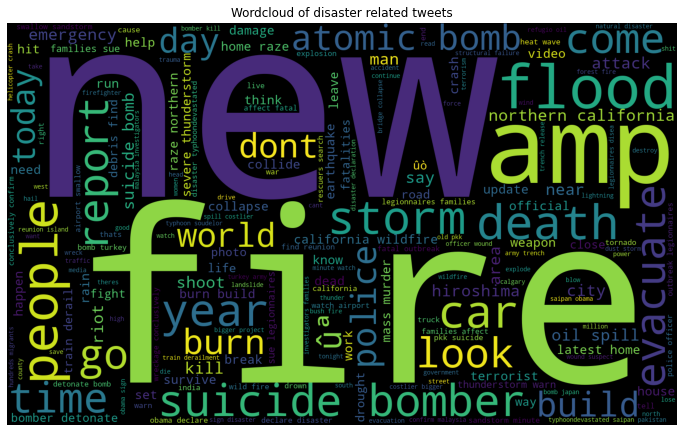

In [ ]:
#___test = data_train['text_cleaned_version'].value_counts().to_dict()
#wc = WordCloud().generate_from_frequencies(___test)

wc = WordCloud(width = 1500, height = 900).generate(' '.join(data_train[data_train['target']==1]['text_cleaned_version'].values))


plt.figure(figsize = (12,8))
plt.imshow(wc)
plt.title("Wordcloud of disaster related tweets")
plt.axis('off')
plt.show()

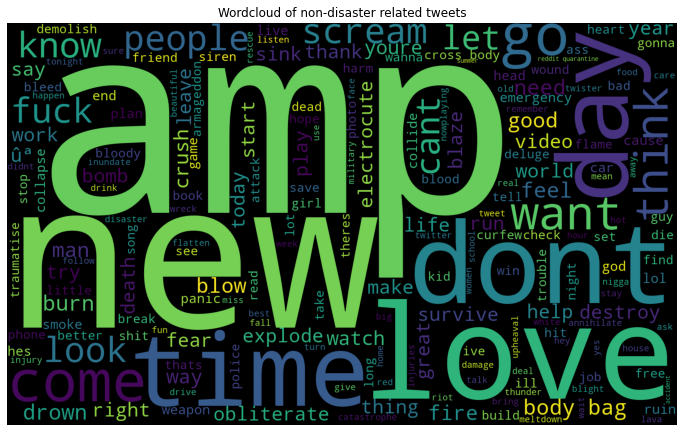

In [ ]:
wc = WordCloud(width = 1500, height = 900).generate(' '.join(data_train[data_train['target']==0]['text_cleaned_version'].values))


plt.figure(figsize = (12,8))
plt.imshow(wc)
plt.title("Wordcloud of non-disaster related tweets")
plt.axis('off')
plt.show()

# Additionnal stopwords
We can definitely see that we have an issue with some words appearing when they shouldn't be taken into account in our wordcloud such as amp, think, fuck, look, come etc

In [ ]:
additionalstopword_list = ['amp','look', 'fuck', 'think','know','come','want', 'year']

def remove_additional_stopwords(tweet):
    """Clears out the noise issue in the wordclouds below"""
    return ' '.join([x for x in tweet.split() if x not in additionalstopword_list])


In [ ]:
data_train["text_cleaned_version"] = data_train["text_cleaned_version"].apply(remove_additional_stopwords)

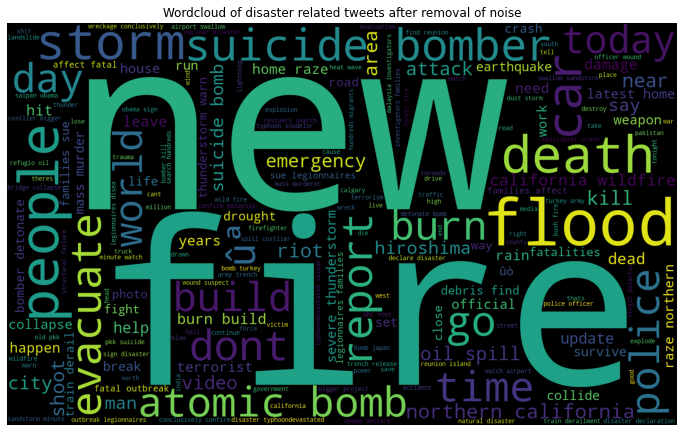

In [ ]:
wc = WordCloud(width = 1500, height = 900).generate(' '.join(data_train[data_train['target']==1]['text_cleaned_version'].values))


plt.figure(figsize = (12,8))
plt.imshow(wc)
plt.title("Wordcloud of disaster related tweets after removal of noise")
plt.axis('off')
plt.show()

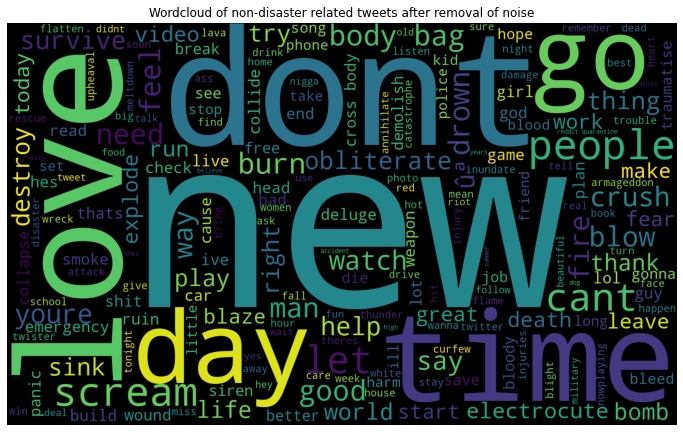

In [ ]:
wc = WordCloud(width = 1500, height = 900).generate(' '.join(data_train[data_train['target']==0]['text_cleaned_version'].values))


plt.figure(figsize = (12,8))
plt.imshow(wc)
plt.title("Wordcloud of non-disaster related tweets after removal of noise")
plt.axis('off')
plt.show()

In [ ]:
# Tfidf transformer 
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words = 'english', smooth_idf = True)
X = vectorizer.fit_transform(data_train['text_cleaned_version'])

# X is a generator. We can transform that as an array
dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Creating a DataFrame with all the words and tf-idf score 
tfid_df = pd.DataFrame(dense, 
                        columns=[x for x in vectorizer.get_feature_names_out()])

tfid_df

,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aampb,aampw,aan,aannnnd,aar,aashiqui,aba,abandon,abbandoned,abbott,abbruchsimulator,abbswinston,abc,abceyewitness,abcnews,abcs,abe,aberdeen,aberystwythshrewsbury,abes,abha,abia,ability,abject,ablaze,able,ableg,aboard,abomb,abombed,abomination,abortion,abortions,abouts,abs,absence,...,ûªt,ûªve,ûï,ûïa,ûïafter,ûïairplane,ûïall,ûïcat,ûïdetonate,ûïfor,ûïhannaph,ûïhatchet,ûïi,ûïkeits,ûïlittle,ûïlove,ûïmake,ûïnews,ûïnobody,ûïnumbers,ûïparties,ûïplans,ûïrichmond,ûïsippin,ûïstretcher,ûïthat,ûïthe,ûïwe,ûïwhen,ûïyou,ûò,ûòthe,ûòåêcnbc,ûó,ûóbbc,ûóher,ûókody,ûónegligence,ûótech,ûówe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Transpose dataframe
#tfid_df = tfid_df.T
# Create a new token column 
#tfid_df["token"] = tfid_df.index
#tfid_df.sort_values(by=0, ascending=False)[:15]

word_count = list()
words = tfid_df.columns.to_list()
word_count = [(tfid_df[z] != 0.0).sum() for z in tfid_df.columns]

In [ ]:
data_word_count = pd.DataFrame(zip(words,word_count), columns = ['word', 'count'])
data_word_count[data_word_count['count']>1].sort_values(by = 'count', ascending=False)[:10]

,word,count
6264,like,371
1235,bomb,218
7369,new,217
8120,people,188
7381,news,185
3093,dont,185
11014,time,168
1472,burn,163
5930,kill,163
4011,flood,154


In [ ]:
data_train.columns

Index(['text', 'target', 'number_of_words', 'text_cleaned_version'], dtype='object')

# Tokenizer

In [ ]:
#We'll check the maximum length of a token to assess the padding needed after (Let's see what is our max length in cleaned words to assess the padding needed on the overall dataset ### Explain padding)
data_train['token_length'] = data_train.text_cleaned_version.apply(lambda x: len(x))
number_of_words = data_train['token_length'].sum()

#Instanciate the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = number_of_words)

#Fit it on the text before encoding it in sequences
tokenizer.fit_on_texts(data_train['text_cleaned_version'])

#Convert it to sequences
data_train['encoded_text'] = tokenizer.texts_to_sequences(data_train['text_cleaned_version'])

#We'll drop as well the useless columns we don't need anymore
data_train = data_train[['text','target','text_cleaned_version','encoded_text','token_length']]



In [ ]:
data_train.columns

Index(['text', 'target', 'text_cleaned_version', 'encoded_text',
       'token_length'],
      dtype='object')

In [ ]:
#Simple verification that we focus only on token that are existing
print('We have {} values before focusing on token >0'.format(data_train.shape[0]))
data_train = data_train[data_train['token_length'] != 0]
print('We have {} values after focusing on token >0'.format(data_train.shape[0]))

We have 7503 values before focusing on token >0
We have 7498 values after focusing on token >0


In [ ]:
data_train.head()

,text,target,text_cleaned_version,encoded_text,token_length
0,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake allah forgive,"[3370, 458, 164, 1429, 1598]",37
1,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada,"[97, 2, 138, 5038, 5039, 1035]",34
2,All residents asked to 'shelter in place' are ...,1,residents ask shelter place notify officer eva...,"[1296, 421, 1599, 318, 5040, 259, 181, 1599, 3...",80
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation order cali...,"[6, 2161, 1036, 181, 276, 27]",52
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfires pou...,"[5, 153, 215, 5041, 1830, 139, 1036, 2162, 91]",54


# Training & Validation Set

# Padding

In [ ]:
#We've seen earlier that 21 was the maximum length of a token, therefore it will assess for our padding
#As I've forgotten to do it before splitting my train set, I'll do it here
max_length_padding = data_train['token_length'].max()
print(max_length_padding)

137


In [ ]:
#Padding
dataset_padding = tf.keras.preprocessing.sequence.pad_sequences(data_train.encoded_text, padding = 'post', maxlen = max_length_padding)

#Build now the full tensorflow dataset taking into account the padding & target
full_dataset = tf.data.Dataset.from_tensor_slices((dataset_padding,data_train.target))
full_dataset



<TensorSliceDataset shapes: ((137,), ()), types: (tf.int32, tf.int64)>

In [ ]:
#Let's slice our dataset now as we saw during our course
#I've chosen first a batch size of 32 as a starting point, ideally it would be best to compare the different batch sizes with the accuracy output

TAKE_SIZE = int(0.8*data_train.shape[0])
batch_size = 32

train = full_dataset.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train = train.batch(batch_size)

val = full_dataset.skip(TAKE_SIZE)
val = val.batch(batch_size)

In [ ]:
for text, target in train.take(1):
  print(text)

tf.Tensor(
[[1630 1417 1418 ...    0    0    0]
 [ 601   24    0 ...    0    0    0]
 [  24  218  801 ...    0    0    0]
 ...
 [ 454   29  888 ...    0    0    0]
 [  58  417  122 ...    0    0    0]
 [ 451 1771    4 ...    0    0    0]], shape=(32, 137), dtype=int32)


In [ ]:
for text2, target in val.take(1):
  print(text2)

tf.Tensor(
[[  358    65    51 ...     0     0     0]
 [  916    49    65 ...     0     0     0]
 [ 4354 11252    65 ...     0     0     0]
 ...
 [11298   723    65 ...     0     0     0]
 [   11   102   128 ...     0     0     0]
 [   51     1    65 ...     0     0     0]], shape=(32, 137), dtype=int32)


In [ ]:
#Account the number of words +1 for our entry 

size_vocab = tokenizer.num_words + int(1)
print(size_vocab)

395329


In [ ]:
#According to documentation, building a simple binary classificator model
model = tf.keras.Sequential([
                             #Couche d'input Embedding
                             tf.keras.layers.Embedding(size_vocab, batch_size, input_shape = [text.shape[1]]),
                             tf.keras.layers.Conv1D(32, 3, activation = 'relu'),
                             # flatten output
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation = 'relu'),
                             tf.keras.layers.Dropout(0.4),
                             tf.keras.layers.Dense(512, activation = 'relu'),
                             #We use a sigmoid in the output layer to represent our probability 0 or 1
                             tf.keras.layers.Dense(1, activation = 'sigmoid')])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 137, 32)           12642560  
                                                                 
 conv1d_2 (Conv1D)           (None, 135, 32)           3104      
                                                                 
 flatten_2 (Flatten)         (None, 4320)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               2212352   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 1)                

In [51]:
# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

# Utilisation d'un compileur simple avec un optimiseur Adam pour le calcul de nos gradients 
optimizer= tf.keras.optimizers.Adam()

#Binary cross entropy is specific to binary classification issues
model.compile(optimizer= optimizer, loss= tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
history = model.fit(train, validation_data = val, epochs = 10)

Epoch 1/10
188/188 [==============================] - 37s 195ms/step - loss: 0.6797 - accuracy: 0.5809 - val_loss: 0.6870 - val_accuracy: 0.5404
Epoch 2/10
188/188 [==============================] - 37s 197ms/step - loss: 0.6479 - accuracy: 0.6261 - val_loss: 0.6152 - val_accuracy: 0.6785
Epoch 3/10
188/188 [==============================] - 38s 202ms/step - loss: 0.4636 - accuracy: 0.7948 - val_loss: 0.4800 - val_accuracy: 0.7805
Epoch 4/10
188/188 [==============================] - 37s 194ms/step - loss: 0.3392 - accuracy: 0.8605 - val_loss: 0.4807 - val_accuracy: 0.7752
Epoch 5/10
188/188 [==============================] - 37s 198ms/step - loss: 0.2631 - accuracy: 0.8982 - val_loss: 0.5127 - val_accuracy: 0.7819
Epoch 6/10
188/188 [==============================] - 36s 190ms/step - loss: 0.2102 - accuracy: 0.9258 - val_loss: 0.5596 - val_accuracy: 0.7685
Epoch 7/10
188/188 [==============================] - 37s 198ms/step - loss: 0.1676 - accuracy: 0.9428 - val_loss: 0.6006 - val_ac

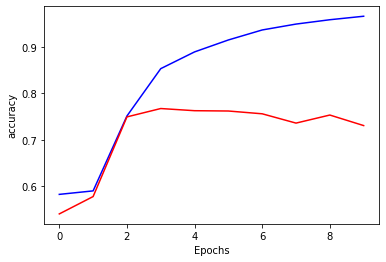

In [ ]:
#Visualization of the training process on the accuracy
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

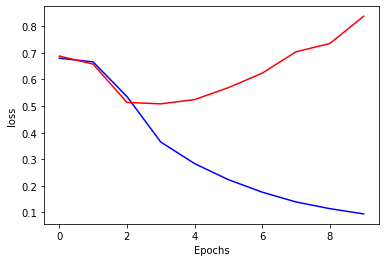

In [ ]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

We'll stop our model at 2 epochs to try and avoid overfit as much as possible
(This was a run after a fresh restart, above cell highlights how far we overtrained the model

In [ ]:
model = tf.keras.Sequential([
                             #Couche d'input Embedding
                             tf.keras.layers.Embedding(size_vocab, batch_size, input_shape = [text.shape[1]]),
                             tf.keras.layers.Conv1D(32, 3, activation = 'relu'),
                             # flatten output
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation = 'relu'),
                             tf.keras.layers.Dropout(0.6),
                             tf.keras.layers.Dense(512, activation = 'relu'),
                             #We use a sigmoid in the output layer to represent our probability 0 or 1
                             tf.keras.layers.Dense(1, activation = 'sigmoid')])

model.compile(optimizer= optimizer, loss= tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

history = model.fit(train, validation_data = val, epochs = 2)

Epoch 1/2
188/188 [==============================] - 41s 212ms/step - loss: 0.6802 - accuracy: 0.5792 - val_loss: 0.6898 - val_accuracy: 0.5400
Epoch 2/2
188/188 [==============================] - 39s 205ms/step - loss: 0.6704 - accuracy: 0.5822 - val_loss: 0.6645 - val_accuracy: 0.5820


In [ ]:
model.save('InitialNLPDL_model_2_without_hashtags.h5')

In [ ]:
#files.download("InitialNLPDL_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Try the model on our test set 

In [ ]:
test_set = pd.read_csv("data/test.csv")

In [ ]:
test_set['text_cleaned_version'] = test_set["text"].apply(basic_clean)
test_set['text_cleaned_version'] = test_set['text_cleaned_version'].apply(remove_additional_stopwords)
test_set['token_length'] = test_set.text_cleaned_version.apply(lambda x: len(x))
number_of_words = test_set['token_length'].sum()

#Instanciate the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = number_of_words)
#Fit it on the text before encoding it in sequences
tokenizer.fit_on_texts(test_set['text_cleaned_version'])

#Convert it to sequences
test_set['encoded_text'] = tokenizer.texts_to_sequences(test_set['text_cleaned_version'])



In [ ]:
test_set['token_length'].min()

0

In [ ]:
test_set[test_set['token_length']==0]

,id,keyword,location,text,text_cleaned_version,token_length,encoded_text
9,29,NaN,NaN,Fuck off!,,0,[]
13,43,NaN,NaN,What if?!,,0,[]
632,2062,casualty,Canada | #LUX,@Rx_Casualty @Vpzedd @Daintt_M call,,0,[]
1722,5810,hail,Ontario CA,Something to think about,,0,[]


In [ ]:
#These 4 lines are not disaster, I'll replace the text by a no disaster strong occurence 
test_set.loc[9, 'text_cleaned_version'] = 'love'
test_set.loc[13, 'text_cleaned_version'] = 'love'
test_set.loc[632, 'text_cleaned_version'] = 'love'
test_set.loc[1722, 'text_cleaned_version'] = 'love'
test_set["encoded_text"] = tokenizer.texts_to_sequences(test_set['text_cleaned_version'])
test_set["token_length"] = test_set["encoded_text"].apply(lambda x: len(x))
test_set[test_set["token_length"]==0]

,id,keyword,location,text,text_cleaned_version,token_length,encoded_text


We'll drop these lines as they couldn't be cleaned (removal of # and the following) and aren't really relevant to the dataset.

Padding and we can proceed to the prediction on test set

In [ ]:
test_dataset_padding = tf.keras.preprocessing.sequence.pad_sequences(test_set.encoded_text, padding = "post", maxlen = max_length_padding)
full_test_set = tf.data.Dataset.from_tensor_slices(test_dataset_padding)

In [ ]:
test_prediction = model.predict(full_test_set.batch(32))
test_prediction

array([[0.15389818],
       [0.686774  ],
       [0.8945469 ],
       ...,
       [0.08805916],
       [0.22867787],
       [0.19275469]], dtype=float32)

In [ ]:
test_prediction = np.round(test_prediction).astype(int).reshape(len(test_set))
test_prediction

array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
test_prediction.shape

(3263,)

In [ ]:
#We have to convert our prediction to a dataframe to be able to see how well we did with the model 
test_final = pd.DataFrame({'id':test_set['id'], 'target':test_prediction})

In [ ]:
test_final.head(10)

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,0
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


Convert to csv our predictions in a submittable format

In [ ]:
test_final.to_csv('predictions_without_hashtag.csv',index = False)

In [ ]:
test_set['target_prediction'] = test_prediction 
test_set.tail(25)

,id,keyword,location,text,text_cleaned_version,token_length,encoded_text,target_prediction
3238,10773,wreckage,NaN,Wreckage 'Conclusively Confirmed' as From MH37...,wreckage conclusively confirm malaysia,38,"[508, 559, 298, 406]",0
3239,10778,wreckage,Mumbai,Wreckage 'Conclusively Confirmed' as From MH37...,wreckage conclusively confirm malaysia investi...,61,"[508, 559, 298, 406, 407, 136]",0
3240,10781,wreckage,our galaxy,RT @australian Debris found on an Indian Ocean...,debris find indian ocean island confirm flight,46,"[214, 98, 1316, 874, 284, 298, 507]",0
3241,10791,wrecked,Sunny Southern California,Cramer: Iger's 3 words that wrecked Disney's s...,cramer igers word wreck disneys stock,37,"[2960, 7612, 416, 166, 2961, 225]",1
3242,10792,wrecked,"Plymouth, England",Almost *wrecked* my van the other day because ...,wreck van day guy yeah brake care animals,41,"[166, 1412, 58, 193, 544, 942, 479, 1196]",0
3243,10796,wrecked,Deep in the heart of LibLand,'What manner of human being would parcel out a...,manner human parcel baby wreck car junk yard t...,59,"[7613, 620, 7614, 216, 166, 61, 7615, 1334, 15...",0
3244,10797,wrecked,NaN,@Nathan26_RFC thought you said Saturday night ...,say saturday night near die lolol youll wreck,45,"[28, 1341, 89, 93, 67, 7617, 905, 166]",1
3245,10801,wrecked,"Canada,Ontario",I just wanna ease your mind and make you feel ...,wanna ease mind feel alright,28,"[950, 7618, 547, 40, 2095]",1
3246,10804,wrecked,Love Reiss,@yakubOObs think he deactivated because his no...,deactivate notifications aid tesco wreck,40,"[2538, 7619, 1846, 7620, 166]",0
3247,10806,wrecked,Seattle Washington,RT CNBC '3 words from Disney CEO Bob Iger wrec...,cnbc word disney ceo bob iger wreck disneys st...,64,"[7621, 416, 1457, 1899, 1191, 7622, 166, 2961,...",1


It's really bad 58%, we need to improve our model , by testing maybe simpler layouts

### We submitted our score, thinking we had a good performance 77%, but we had over-trained our model, after a fresh re-run the real performance is 58% 

## Conclusion 
- We need to prepare our data better, this might be what is dragging our performance down
- We need to look into transformers such as DistilBERT or BERT to see if it helps in the process
- We should try other neural network forms

This project needs to be re-worked 
